In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [5]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [3]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [4]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'data/{target_column}_{city}.csv',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [22]:
for city, state, conties in cities:
    df0 = pd.read_csv(f'data/S000_{city}.csv')
    df1 = pd.read_csv(f'data/SE01_{city}.csv')
    df3 = pd.read_csv(f'data/SE03_{city}.csv')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_csv(f'data/merged_{city}.csv', index=False)

# baseline

### unconstrain model, power law

In [2]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [3]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [6]:
minValue = []
maxValue = []
for city, state, conties in cities:
    df = pd.read_csv(f'data/merged_{city}.csv')
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-2.120014812572229 5.2031663975706754


In [11]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

In [83]:
distBin = np.linspace(np.log(0.5),np.log(50),40+1)
distBin

array([-6.93147181e-01, -5.78017926e-01, -4.62888671e-01, -3.47759417e-01,
       -2.32630162e-01, -1.17500907e-01, -2.37165266e-03,  1.12757602e-01,
        2.27886857e-01,  3.43016111e-01,  4.58145366e-01,  5.73274621e-01,
        6.88403875e-01,  8.03533130e-01,  9.18662385e-01,  1.03379164e+00,
        1.14892089e+00,  1.26405015e+00,  1.37917940e+00,  1.49430866e+00,
        1.60943791e+00,  1.72456717e+00,  1.83969642e+00,  1.95482568e+00,
        2.06995493e+00,  2.18508419e+00,  2.30021344e+00,  2.41534269e+00,
        2.53047195e+00,  2.64560120e+00,  2.76073046e+00,  2.87585971e+00,
        2.99098897e+00,  3.10611822e+00,  3.22124748e+00,  3.33637673e+00,
        3.45150599e+00,  3.56663524e+00,  3.68176450e+00,  3.79689375e+00,
        3.91202301e+00])

## find optimal bin

#### determined to use 40 bins from the figure above

In [119]:
# expand bin to include the nearest datapoints
def mergeBin(df):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
    thre = max(int(0.005*len(df)),2000)
    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)

            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [123]:

# arbitarily set bin=40

resultsfd40 = {}
bindffDict = {}
resultsBaseline = {}

for city, state, conties in cities:
    print(city)
    df = pd.read_csv(f'data/merged_{city}.csv')
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(minValue,maxValue,40+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        binf,k = unconstrained_bucked_constant_kfit(df, target)
        print(target,k)
        df_fd = unconstrained_bucked_constant_kpredict(df,target,k,binf)
        binfOrigin = df_fd[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40[city] = resultsfd40.get(city,[])+ \
                [mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])]
    # baseline 

    for target in ['SE01','SE03','S000']:

        pars = baseline_fit(df,target)
        df_baseline = baseline_predict(df,target,pars)
        resultsBaseline[city] = resultsBaseline.get(city,[]) + \
            [mean_squared_error(df_baseline[target+'flow'],df_baseline[target+'pred'])]

New York City
SE01 2.380976260994591e-06
SE03 8.32640038926537e-07
S000 4.093400702755677e-07
Los Angeles
SE01 1.7902504292041524e-06
SE03 7.585079885980522e-07
S000 3.603477336192089e-07
Chicago
SE01 3.023985743821124e-06
SE03 1.5254626922601893e-06
S000 7.449396742170164e-07
Houston
SE01 3.878054072083325e-06
SE03 1.5077776573371737e-06
S000 7.402389018641345e-07
Boston
SE01 7.916143522520647e-06
SE03 2.0226940588216863e-06
S000 1.213228878483735e-06
Phoenix
SE01 3.2929044040726184e-06
SE03 1.3095928316814264e-06
S000 6.14714575457463e-07
Philadelphia
SE01 1.2988757408094762e-05
SE03 6.835926272120218e-06
S000 2.8706572021205987e-06
San Antonio
SE01 7.293359928148386e-06
SE03 4.101826370962668e-06
S000 1.6815558670199684e-06
San Diego
SE01 5.036441172908027e-06
SE03 1.8612684569930248e-06
S000 9.11741027002758e-07
Dallas
SE01 7.029057342277772e-06
SE03 2.973644960190162e-06
S000 1.376374351084915e-06
San Jose
SE01 1.2810776730830717e-05
SE03 2.500592314893867e-06
S000 1.6221714757466

In [125]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income1[bins],income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income3[bins],income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income0[bins],income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

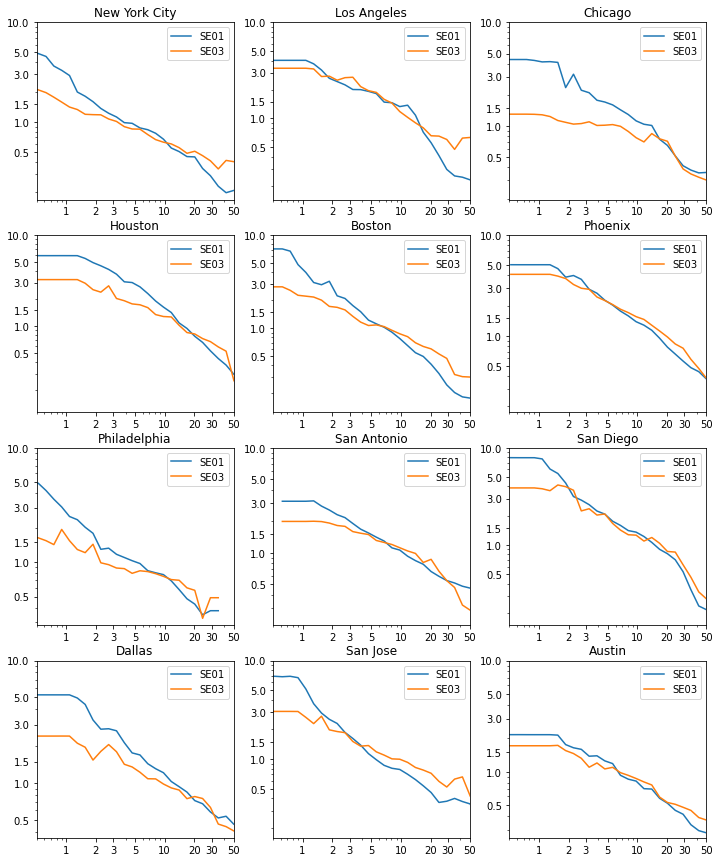

In [127]:
# 0.5% / 2000

fig,ax = plt.subplots(4,3,figsize=(12,15))
i= 0
for city, state, conties in cities:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    ax[i//3,i%3].set_xlim(0.5,50)
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df = df.sort_values(by='bin')
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    i += 1
      
plt.savefig('curve.png')